# Confidence scores figure
June 30, 2021

In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R') # imports
    source('../R/utils.R') # useful functions
    library(pROC)
})

# Colors for each cell state
group.colors.nocent = group.colors[-28]
colors = c('Unseen in reference' = 'coral1', 'Seen in reference' = 'aquamarine4')

## Read in data

Load data

In [2]:
exprs_3p = readRDS('../data/Fig5_fetal_liver/exprs_3p.rds')
metadata_3p = readRDS('../data/Fig5_fetal_liver/metadata_3p.rds')

dim(exprs_3p)
dim(metadata_3p)

metadata_3p$cell.labels = plyr::mapvalues(metadata_3p$cell.labels, 
    from = c('Early lymphoid_T lymphocyte', 'Neutrophil-myeloid progenitor', 'VCAM1+ EI macrophage'),
    to = c('Early lymphoid/T', 'Neut-myeloid prog.', 'VCAM1+ EI macro.'))

table(metadata_3p$donor)

[1]  27080 113063

[1] 113063     18


  F10   F11   F12   F13   F14   F15   F16    F2    F3    F4    F5    F6    F7 
 5658  8369  9425  9730  6657  6904  5315  6753  8821  1135 15401  1992  9958 
   F8 
16945 

Hold out a donor as query.

In [3]:
set.seed(0)
donor = sample(metadata_3p$donor, 1)
donor

table(metadata_3p$cell.labels[which(metadata_3p$donor == donor)])

[1] F8
Levels: F10 F11 F12 F13 F14 F15 F16 F2 F3 F4 F5 F6 F7 F8


            B cell       DC precursor                DC1                DC2 
                87                 14                 56                292 
   Early Erythroid   Early lymphoid/T   Endothelial cell         Fibroblast 
              1131                 57                321                361 
        Hepatocyte            HSC_MPP      ILC precursor       Kupffer Cell 
               306                292                340               6022 
    Late Erythroid          Mast cell      Megakaryocyte               MEMP 
               235                 78                570                166 
     Mid Erythroid           Mono-Mac           Monocyte Monocyte precursor 
              2833               1035                375                 44 
Neut-myeloid prog.                 NK      pDC precursor     Pre pro B cell 
                91               1976                  9                 12 
        pre-B cell         pro-B cell   VCAM1+ EI macro. 
                8

# Reference missing non-immune cells

## Build reference (missing non-immune cell types)

Reference/query split
* Here, we will remove a donor for which there will be "unseen" non-immune cells.

In [4]:
toremove = c('Hepatocyte', 'Fibroblast', 'Endothelial cell') # change this line in other sections
filename_label = paste('missing', 'Hepatocyte_Fibroblast_Endothelial', sep = '_')
outdir = '/data/srlab2/jkang/symphony_reproducibility/confidence_score/results_fetal_liver/'

print(filename_label)
table(metadata_3p$donor, metadata_3p$cell.labels)[donor, toremove]

[1] "missing_Hepatocyte_Fibroblast_Endothelial"


Hepatocyte       Fibroblast Endothelial cell 
             306              361              321

In [5]:
# Colors for each cell state - show 'present in reference' as grey
group.colors.missing = c(   'B cell'= 'lightgrey',
                    'DC precursor'='lightgrey',
                    'DC1'='lightgrey',
                    'DC2'='lightgrey',
                    'Early Erythroid'='lightgrey',
                    'Early lymphoid/T'='lightgrey',
                    'Endothelial cell'='#4f8c9d',
                    'Fibroblast'='#eb1fcb',
                    'Hepatocyte'='#f5cdaf',
                    'HSC_MPP'='lightgrey',
                    'ILC precursor'='lightgrey',
                    'Kupffer Cell'='lightgrey',
                    'Late Erythroid'='lightgrey',
                    'Mast cell'='lightgrey',
                    'Megakaryocyte'='lightgrey',
                    'MEMP'='lightgrey',
                    'Mid Erythroid'='lightgrey',
                    'Mono-Mac'='lightgrey',
                    'Monocyte'='lightgrey',
                    'Monocyte precursor'='lightgrey',
                    'Neut-myeloid prog.'='lightgrey',
                    'NK'='lightgrey',
                    'pDC precursor'='lightgrey',
                    'Pre pro B cell'='lightgrey',
                    'pre-B cell'='lightgrey',
                    'pro-B cell'='lightgrey',
                    'VCAM1+ EI macro.'='lightgrey')

In [6]:
idx_query = which(metadata_3p$donor %in% donor)

ref_exp = exprs_3p[, -idx_query]
ref_metadata = metadata_3p[-idx_query, ]
query_exp = exprs_3p[, idx_query]
query_metadata = metadata_3p[idx_query, ]

# Simulate an "unseen" cell type in the query
idx_toRemove = which(ref_metadata$cell.labels %in% toremove)

ref_exp = ref_exp[, -idx_toRemove]
ref_metadata = ref_metadata[-idx_toRemove, ]

ncol(ref_exp)
ncol(query_exp)

[1] 89566

[1] 16945

Normalize, variable genes, PCA

Follow the original authors' variable gene selection process: https://github.com/haniffalab/FCA_liver/blob/master/pipelines/06_add_dr/add_dr.R

In [7]:
ref_exp_norm = singlecellmethods::normalizeData(ref_exp, 1e4, 'log')

## Same vargene selection procedure as Popescue et al.
groups = rep('A', ncol(ref_exp_norm))
vargenes = singlecellmethods::findVariableGenes(ref_exp_norm, groups = groups, 
                                                min_expr = .0125, max_expr = 3, min_dispersion = 0.625)
nrow(vargenes)
ref_exp_vargenes = ref_exp_norm[vargenes$symbol, ]
vargenes_means_sds = tibble(symbol = vargenes$symbol, mean = Matrix::rowMeans(ref_exp_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp_vargenes, vargenes_means_sds$mean)
ref_exp_scaled = singlecellmethods::scaleDataWithStats(ref_exp_vargenes, vargenes_means_sds$mean, 
                                                       vargenes_means_sds$stddev, 1)
set.seed(1)
# Run SVD, save gene loadings
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs x cells]
loadings = s$u

[1] 1633

Harmony

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 4478300)”


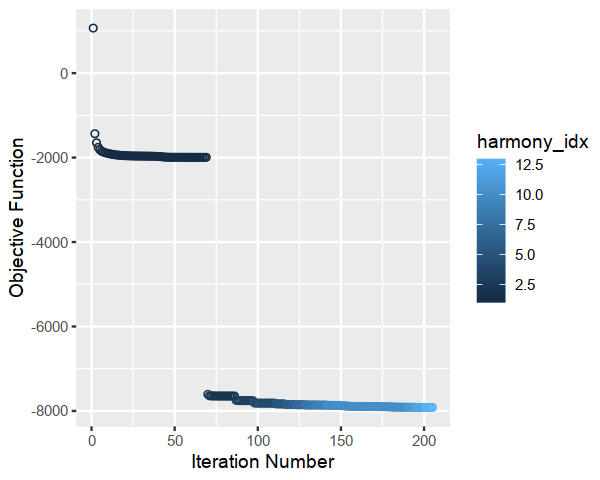

In [8]:
fig.size(4, 5)
set.seed(1)
# Harmonize the reference
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(3),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE,           ## do not recompute PCs
        plot_convergence = TRUE,
        verbose = FALSE
)

Symphony compression

In [11]:
# Compress Harmony obj into a Symphony reference
reference = buildReferenceFromHarmonyObj(
                ref_harmObj,            # output object from HarmonyMatrix()
                ref_metadata,
                vargenes_means_sds,     # gene names, means, and std devs for scaling
                loadings,               # genes x PCs
                verbose = TRUE, 
                do_umap = TRUE,
                umap_min_dist = 0.3, 
                save_uwot_path = paste0(outdir, filename_label, '_uwot_model'))

saveRDS(reference, paste0(outdir, filename_label, '_reference.rds'))

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model

Finished nicely.



Plot reference

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Adding missing grouping variables: `cell.labels`



png 
  2

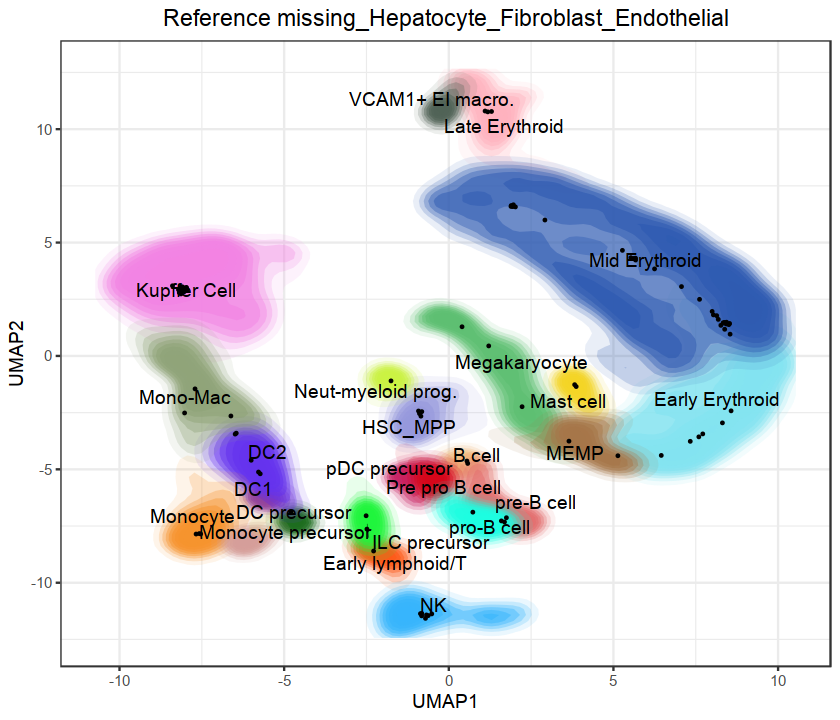

In [12]:
fig.size(6, 7)
p = symphony::plotReference(reference, color.by = 'cell.labels',
                        as.density = TRUE, show.centroids = TRUE, celltype.colors = group.colors,
                        title = paste0('Reference ', filename_label)) + theme(legend.position = 'none')
pdf(paste0('figs_fetal_liver/', filename_label, '_ref_umap.pdf'), width = 7, height = 6, useDingbats = FALSE)
print(p)
dev.off()
p

## Map held-out query

In [13]:
dim(query_exp)
dim(query_metadata)

[1] 27080 16945

[1] 16945    18

In [14]:
reference = readRDS(paste0(outdir, filename_label, '_reference.rds'))
query = mapQuery(query_exp, query_metadata, reference, vars = c('donor'), do_normalize = TRUE)

Normalizing

Scaling and synchronizing query gene expression

Found 1633 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [15]:
saveRDS(query, paste0(outdir, filename_label, '_query.rds'))

## Plotting

In [7]:
query = readRDS(paste0(outdir, filename_label, '_query.rds'))
reference = readRDS(paste0(outdir, filename_label, '_reference.rds'))

In [8]:
# Sync column names
r_metadata = reference$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor')]
q_metadata = query$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor')]
colnames(q_metadata) = colnames(r_metadata)

r_metadata$ref_query = 'reference'
q_metadata$ref_query = 'query'
meta_data_combined = rbind(q_metadata, r_metadata)

# Add the UMAP coordinates to the metadata
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# To plot query cells on top
umap_combined_labels = umap_combined_labels[order(- as.numeric(factor(umap_combined_labels$ref_query))),]

Adding missing grouping variables: `cell.labels`



png 
  2

png 
  2

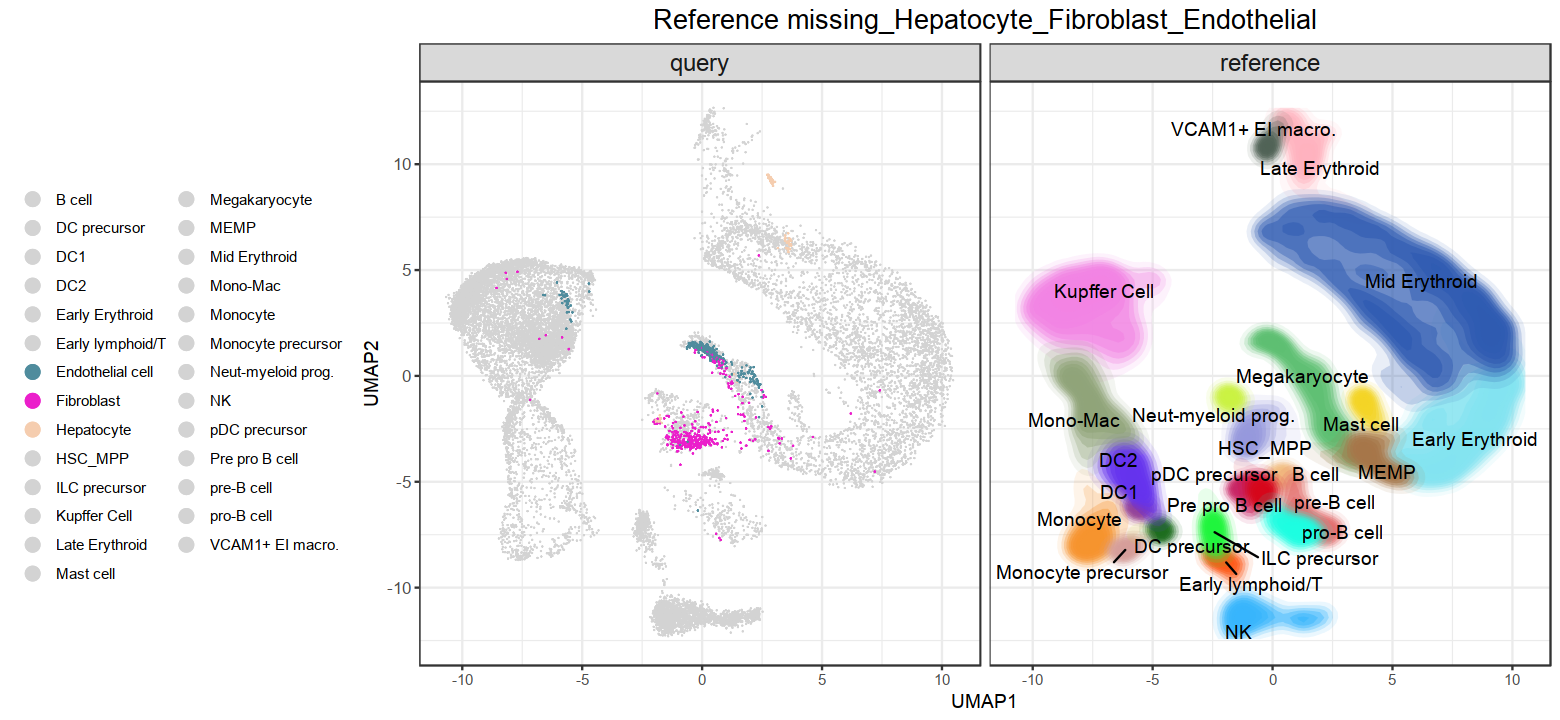

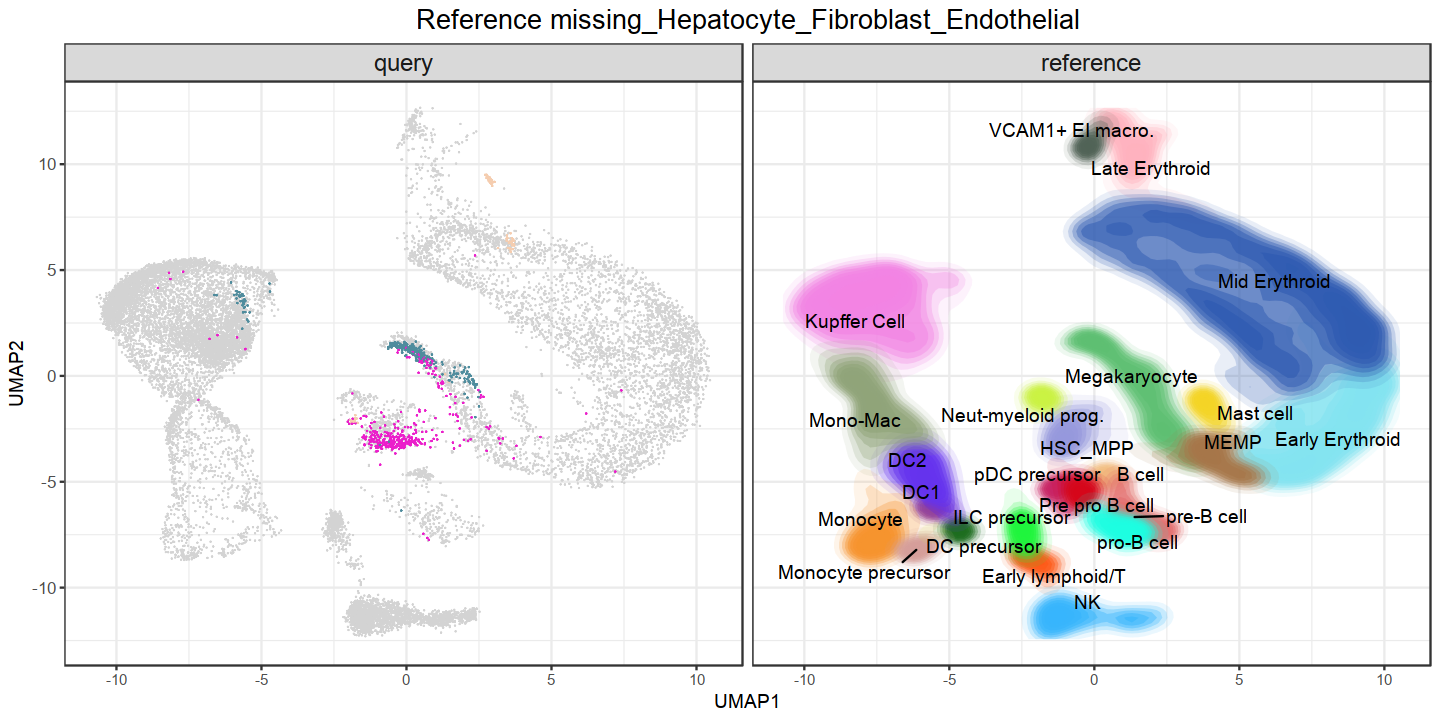

In [9]:
res = umap_combined_labels
res_ref = res[which(res$ref_query == 'reference'), ]
res_new = res[which(res$cell.labels %in% toremove), ]

# Make cell type labels
labels.cent = res_ref %>% 
    dplyr::group_by(cell.labels) %>%
    dplyr::select(UMAP1, UMAP2) %>% 
    summarize_all(median)

p = res_ref %>%
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell.labels), 
                        contour_var = "ndensity", bins = 10, h = 1.5, show.legend = FALSE) +
        geom_point_rast(data = res[which(res$ref_query == 'query'), ], 
                   aes(x = UMAP1, y = UMAP2, color = cell.labels), size = 0.4, stroke = 0.3, shape = 16) +
        # plot unseen cells on top
        geom_point_rast(data = sample_frac(res_new, 1), 
                   aes(x = UMAP1, y = UMAP2, color = cell.labels), size = 0.4, stroke = 0.3, shape = 16) +
        theme_bw() +
        labs(title = '', color = '', fill = '') + 
        ggtitle(paste0('Reference ', filename_label)) +
        theme(plot.title = element_text(hjust = 0.5, size = 16)) + 
        scale_fill_manual(values = group.colors) + guides(colour = guide_legend(override.aes = list(size = 4))) +
        scale_color_manual(values = group.colors.missing) + facet_wrap(~ref_query) +
        theme(axis.text.y = element_text(hjust = 1, size=10), strip.text.x = element_text(size=14)) +
        theme(legend.position = 'left') +
        ggrepel::geom_text_repel(data = data.frame(labels.cent, ref_query = 'reference'), 
                                 aes(label = cell.labels), color = 'black', size = 4, max.overlaps = 27) 
fig.size(6, 13)
pdf(paste0('figs_fetal_liver/', filename_label, '_query_umap.pdf'), width = 13, height = 6, useDingbats = FALSE)
print(p)
dev.off()
p

fig.size(6, 12)
q = p + theme(legend.position = 'none')
pdf(paste0('figs_fetal_liver/', filename_label, '_query_umap_nolegend.pdf'), width = 12, height = 6, useDingbats = FALSE)
print(q)
dev.off()
q

## Calculate mapping quality scores

Per-cell mapping metric

png 
  2

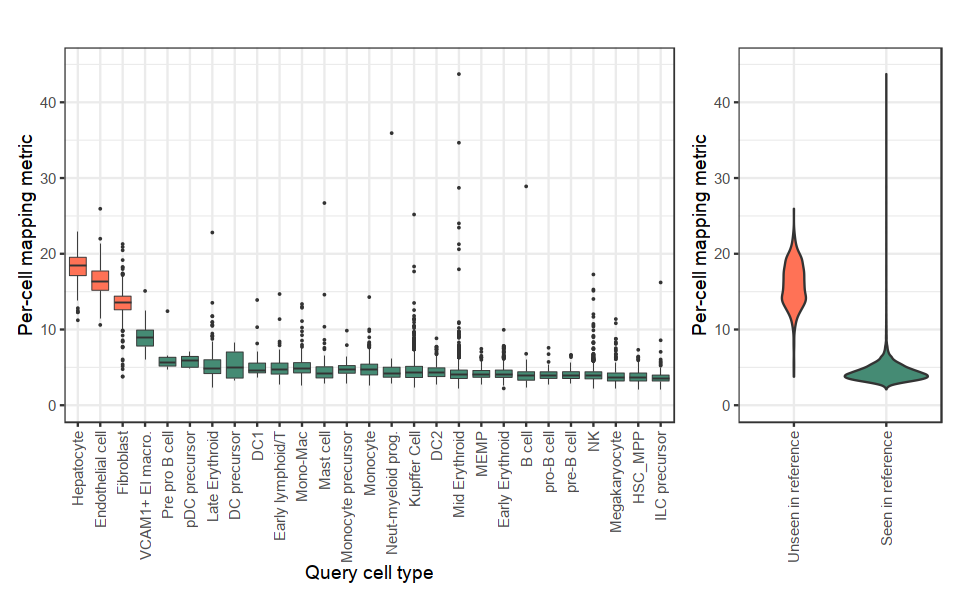

In [10]:
query$meta_data$per_cell_metric = calcPerCellMappingMetric(reference, query, Z_orig = TRUE)

query$meta_data$missing_in_reference = 'Unseen in reference'
query$meta_data$missing_in_reference[- which(query$meta_data$cell.labels %in% toremove)] = 'Seen in reference'
query$meta_data$missing_in_reference = as.factor(query$meta_data$missing_in_reference)

fig.size(5, 8)

cell.labels_order = reorder(query$meta_data$cell.labels, -query$meta_data$per_cell_metric)

p = ggplot(query$meta_data, aes(x = cell.labels_order, y = per_cell_metric, 
                            fill = missing_in_reference)) + theme_bw() + 
    geom_boxplot(outlier.size = 0.01, size = 0.2) + ylab('Per-cell mapping metric') + 
    xlab('Query cell type') + scale_fill_manual(values = colors) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ggtitle('') + theme(legend.position = 'none') +
    theme(legend.title = element_blank()) + theme(plot.title = element_text(hjust = 0.5), 
                                                  plot.subtitle = element_text(hjust = 0.5)) + ylim(0, 45)
q = ggplot(query$meta_data) + 
    geom_violin(aes(fill = missing_in_reference, y = per_cell_metric, 
                     x = reorder(missing_in_reference, - per_cell_metric))) + 
    theme(legend.title = element_blank()) + theme_bw() + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ylab('Per-cell mapping metric') + scale_fill_manual(values = colors) + xlab('') + ylim(0, 45)

myplot = p + q + plot_layout(widths = c(3, 1))

pdf(paste0('figs_fetal_liver/per_cell_metric_', filename_label, '.pdf'), 
    width = 8, height = 5, useDingbats = FALSE)
print(myplot)
dev.off()
myplot

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases



png 
  2

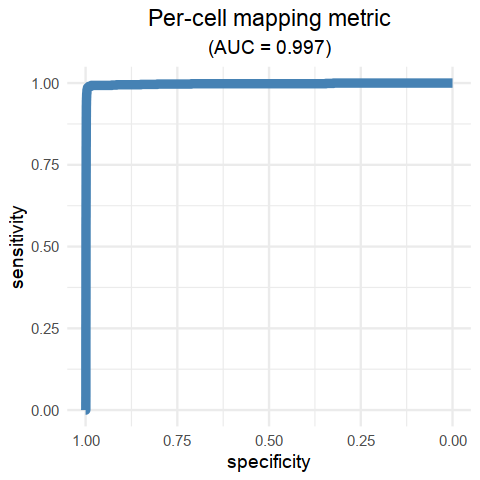

In [11]:
fig.size(4, 4)
rocobj = roc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric)
auc = round(auc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric), 3)

pdf(paste0('figs_fetal_liver/per_cell_auc_', filename_label, '.pdf'), 
    width = 4, height = 4, useDingbats = FALSE)
p = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Per-cell mapping metric')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
print(p)
dev.off()
p

Per-cluster mapping metric

In [12]:
per_cluster_metric = calcPerClusterMappingMetric(reference = reference, query = query, 
                         query_cluster_labels = query$meta_data$cell.labels, u = 2)
per_cluster_metric$missing_in_reference = per_cluster_metric$query_cluster %in% toremove
per_cluster_metric$seen_in_reference = 'Seen in reference'
per_cluster_metric$seen_in_reference[which(per_cluster_metric$missing_in_reference)] = 'Unseen in reference'

Calculating mapping confidence for 27 query clusters

(Warning) cluster contains too few cells to estimate confidence: pDC precursor

(Warning) cluster contains too few cells to estimate confidence: Pre pro B cell

(Warning) cluster contains too few cells to estimate confidence: DC precursor



In [13]:
# Order the cell types in the same order as above.
per_cluster_metric$query_cluster = factor(per_cluster_metric$query_cluster, levels = levels(cell.labels_order))

Warning message:
“Removed 3 rows containing missing values (position_stack).”


png 
  2

Warning message:
“Removed 3 rows containing missing values (position_stack).”


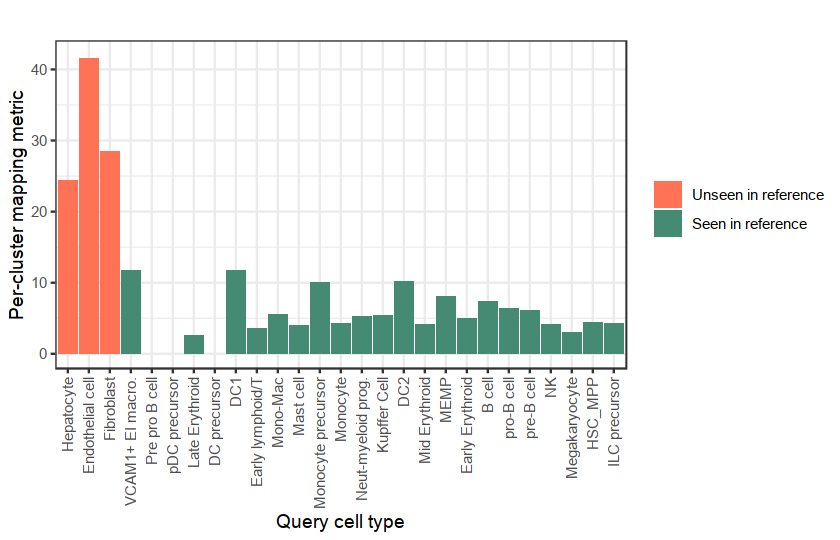

In [14]:
p = ggplot(per_cluster_metric) +
    theme_bw() + 
    geom_bar(aes(x = query_cluster, y = distance_score, 
                 fill = seen_in_reference), stat = 'identity') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    scale_fill_manual(values = colors) + theme(legend.title = element_blank()) +
    ggtitle('') + theme(plot.title = element_text(hjust = 0.5)) + 
    ylab('Per-cluster mapping metric') + xlab('Query cell type') + ylim(0, 42)

fig.size(4.5, 7)
pdf(paste0('figs_fetal_liver/per_cluster_metric_', filename_label, '.pdf'), 
    width = 7, height = 4.5, useDingbats = FALSE)
plot(p)
dev.off()
p

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases



png 
  2

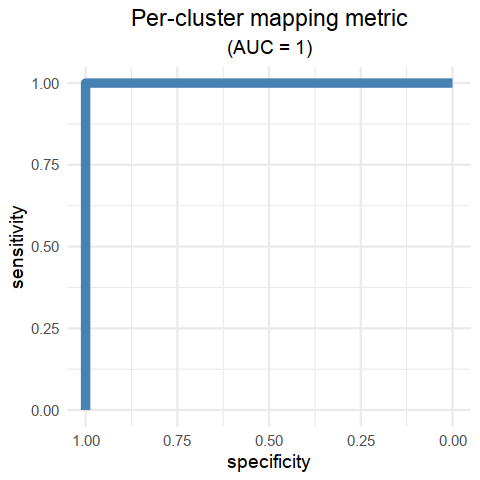

In [15]:
colnames(per_cluster_metric) = c('cell.labels', 'per_cluster_metric')
per_cluster = merge(x = query$meta_data, y = per_cluster_metric, by = "cell.labels", all.x = TRUE)

# For fairness, we set all NA values (small clusters for which we cannot estimate the covariance
# stabily) to 0.
per_cluster[is.na(per_cluster)] = 0

rocobj = roc(per_cluster$missing_in_reference, per_cluster$per_cluster_metric)
auc = round(auc(per_cluster$missing_in_reference, per_cluster$per_cluster_metric), 3)
    
fig.size(4, 4)
pdf(paste0('figs_fetal_liver/per_cluster_auc_', filename_label, '.pdf'), 
    width = 4, height = 4, useDingbats = FALSE)
p = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Per-cluster mapping metric')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
print(p)
dev.off()
p

# Reference missing all myeloid cells

## Build reference

Reference/query split
* Here, we will remove a donor for which there will be "unseen" non-immune cells.

In [16]:
toremove = c('Kupffer Cell', 'Mono-Mac', 'Monocyte', 'Monocyte precursor', 
             'DC1', 'DC2', 'VCAM1+ EI macro.', 'Neut-myeloid prog.',
             'DC precursor', 'pDC precursor') # change this line in other sections
filename_label = paste('missing', 'Myeloid', sep = '_')

outdir = '/data/srlab2/jkang/symphony_reproducibility/confidence_score/results_fetal_liver/'

print(filename_label)
table(metadata_3p$donor, metadata_3p$cell.labels)[donor, toremove]

[1] "missing_Myeloid"


Kupffer Cell           Mono-Mac           Monocyte Monocyte precursor 
              6022               1035                375                 44 
               DC1                DC2   VCAM1+ EI macro. Neut-myeloid prog. 
                56                292                 52                 91 
      DC precursor      pDC precursor 
                14                  9

In [17]:
# Colors for each cell state - show 'present in reference' as grey
group.colors.missing = c(   'B cell'= 'lightgrey',
                    'DC precursor'='#1d6d1f',
                    'DC1'='#8c3ba0',
                    'DC2'='#6533ed',
                    'Early Erythroid'='lightgrey',
                    'Early lymphoid/T'='lightgrey',
                    'Endothelial cell'='lightgrey',
                    'Fibroblast'='lightgrey',
                    'Hepatocyte'='lightgrey',
                    'HSC_MPP'='lightgrey',
                    'ILC precursor'='lightgrey',
                    'Kupffer Cell'='#f283e3',
                    'Late Erythroid'='lightgrey',
                    'Mast cell'='lightgrey',
                    'Megakaryocyte'='lightgrey',
                    'MEMP'='lightgrey',
                    'Mid Erythroid'='lightgrey',
                    'Mono-Mac'='#90a479',
                    'Monocyte'='#f6932e',
                    'Monocyte precursor'='#d59e9a',
                    'Neut-myeloid prog.'='#caf243',
                    'NK'='lightgrey',
                    'pDC precursor'='#c82565',
                    'Pre pro B cell'='lightgrey',
                    'pre-B cell'='lightgrey',
                    'pro-B cell'='lightgrey',
                    'VCAM1+ EI macro.'='#506356')

In [18]:
idx_query = which(metadata_3p$donor %in% donor)

ref_exp = exprs_3p[, -idx_query]
ref_metadata = metadata_3p[-idx_query, ]
query_exp = exprs_3p[, idx_query]
query_metadata = metadata_3p[idx_query, ]

# Simulate an "unseen" cell type in the query
idx_toRemove = which(ref_metadata$cell.labels %in% toremove)

ref_exp = ref_exp[, -idx_toRemove]
ref_metadata = ref_metadata[-idx_toRemove, ]

ncol(ref_exp)
ncol(query_exp)

[1] 64049

[1] 16945

Normalize, variable genes, PCA

Follow the original authors' variable gene selection process: https://github.com/haniffalab/FCA_liver/blob/master/pipelines/06_add_dr/add_dr.R

In [19]:
ref_exp_norm = singlecellmethods::normalizeData(ref_exp, 1e4, 'log')

## Same vargene selection procedure as Popescue et al.
groups = rep('A', ncol(ref_exp_norm))
vargenes = singlecellmethods::findVariableGenes(ref_exp_norm, groups = groups, 
                                                min_expr = .0125, max_expr = 3, min_dispersion = 0.625)
nrow(vargenes)
ref_exp_vargenes = ref_exp_norm[vargenes$symbol, ]
vargenes_means_sds = tibble(symbol = vargenes$symbol, mean = Matrix::rowMeans(ref_exp_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp_vargenes, vargenes_means_sds$mean)
ref_exp_scaled = singlecellmethods::scaleDataWithStats(ref_exp_vargenes, vargenes_means_sds$mean, 
                                                       vargenes_means_sds$stddev, 1)

set.seed(1)
# Run SVD, save gene loadings
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs x cells]
loadings = s$u

[1] 1776

Harmony

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 3202450)”


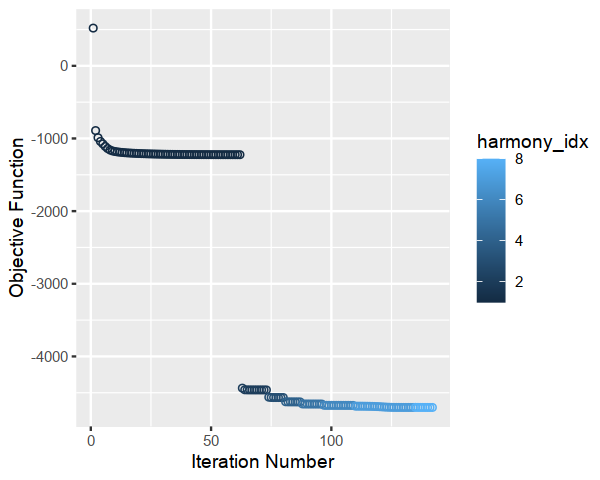

In [30]:
fig.size(4, 5)
set.seed(1)
# Harmonize the reference
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(3),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE,           ## do not recompute PCs
        plot_convergence = TRUE,
        verbose = FALSE
)

Symphony compression

In [31]:
# Compress Harmony obj into a Symphony reference
reference = buildReferenceFromHarmonyObj(
                ref_harmObj,            # output object from HarmonyMatrix()
                ref_metadata,
                vargenes_means_sds,     # gene names, means, and std devs for scaling
                loadings,               # genes x PCs
                verbose = TRUE, 
                do_umap = TRUE,
                umap_min_dist = 0.3, 
                save_uwot_path = paste0(outdir, filename_label, '_uwot_model'))

saveRDS(reference, paste0(outdir, filename_label, '_reference.rds'))

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model

Finished nicely.



Plot reference

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Adding missing grouping variables: `cell.labels`



png 
  2

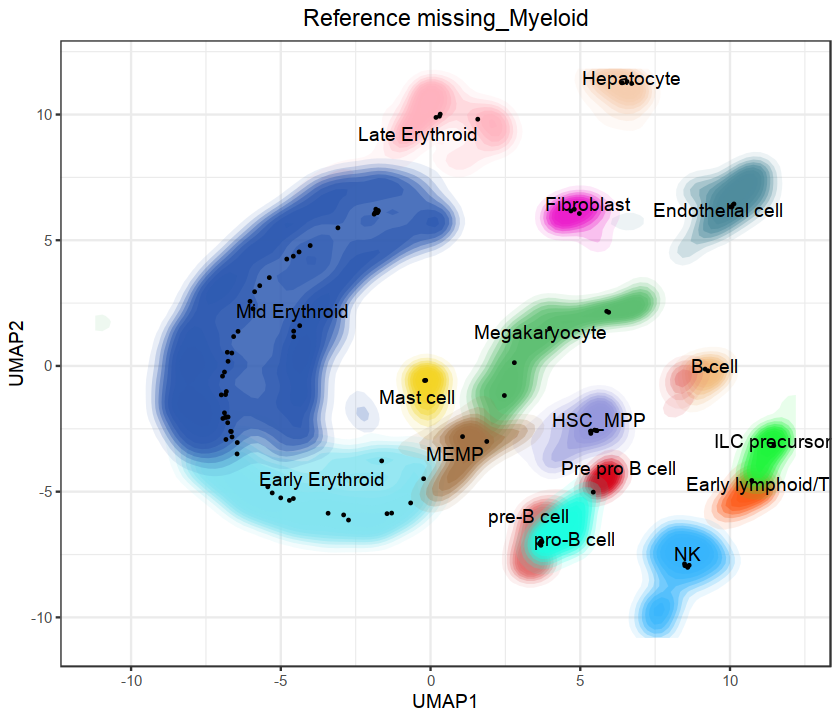

In [32]:
fig.size(6, 7)
p = symphony::plotReference(reference, color.by = 'cell.labels',
                        as.density = TRUE, show.centroids = TRUE, celltype.colors = group.colors,
                        title = paste0('Reference ', filename_label)) + theme(legend.position = 'none')
pdf(paste0('figs_fetal_liver/', filename_label, '_ref_umap.pdf'), width = 7, height = 6, useDingbats = FALSE)
print(p)
dev.off()
p

## Map held-out query

In [20]:
dim(query_exp)
dim(query_metadata)

[1] 27080 16945

[1] 16945    18

In [34]:
reference = readRDS(paste0(outdir, filename_label, '_reference.rds'))
query = mapQuery(query_exp, query_metadata, reference, vars = c('donor'), do_normalize = TRUE)

Normalizing

Scaling and synchronizing query gene expression

Found 1776 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [35]:
saveRDS(query, paste0(outdir, filename_label, '_query.rds'))

## Plotting

In [20]:
query = readRDS(paste0(outdir, filename_label, '_query.rds'))
reference = readRDS(paste0(outdir, filename_label, '_reference.rds'))

In [21]:
# Sync column names
r_metadata = reference$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor')]
q_metadata = query$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor')]
colnames(q_metadata) = colnames(r_metadata)

r_metadata$ref_query = 'reference'
q_metadata$ref_query = 'query'
meta_data_combined = rbind(q_metadata, r_metadata)

# Add the UMAP coordinates to the metadata
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# To plot query cells on top
umap_combined_labels = umap_combined_labels[order(- as.numeric(factor(umap_combined_labels$ref_query))),]

Adding missing grouping variables: `cell.labels`



png 
  2

png 
  2

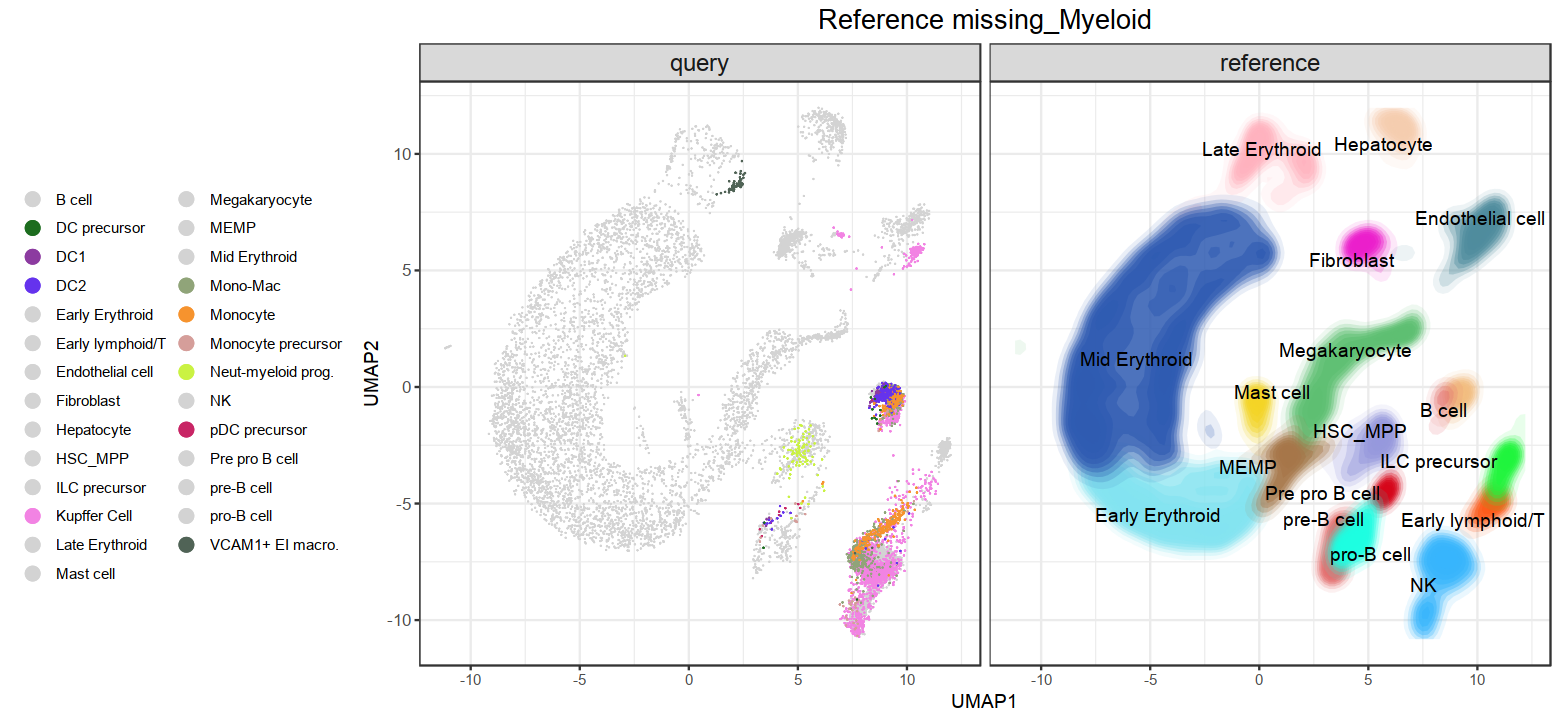

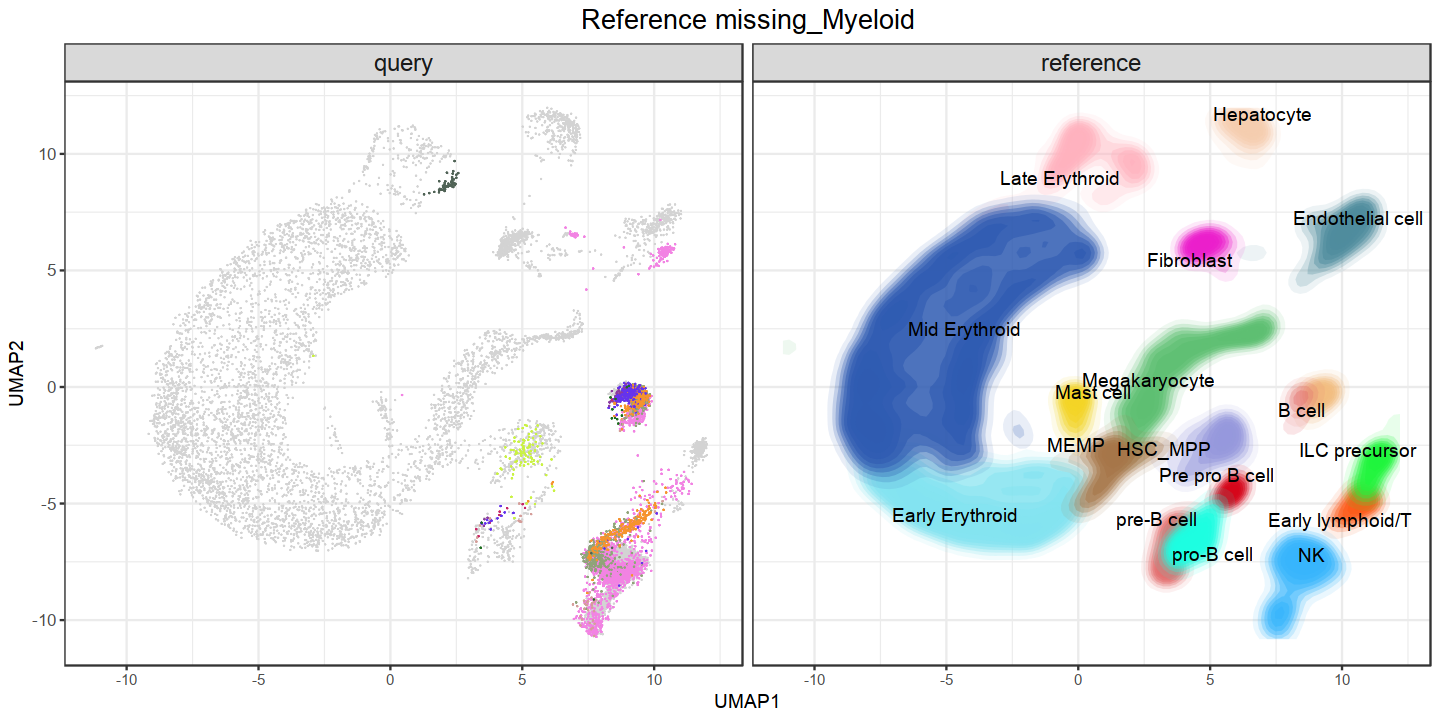

In [22]:
res = umap_combined_labels
res_ref = res[which(res$ref_query == 'reference'), ]
res_new = res[which(res$cell.labels %in% toremove), ]

# Make cell type labels
labels.cent = res_ref %>% 
    dplyr::group_by(cell.labels) %>%
    dplyr::select(UMAP1, UMAP2) %>% 
    summarize_all(median)

p = res_ref %>%
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell.labels), 
                        contour_var = "ndensity", bins = 10, h = 1.5, show.legend = FALSE) +
        geom_point_rast(data = res[which(res$ref_query == 'query'), ], 
                   aes(x = UMAP1, y = UMAP2, color = cell.labels), size = 0.4, stroke = 0.3, shape = 16) +
        # plot unseen cells on top
        geom_point_rast(data = res_new, 
                   aes(x = UMAP1, y = UMAP2, color = cell.labels), size = 0.4, stroke = 0.3, shape = 16) +
        theme_bw() +
        labs(title = '', color = '', fill = '') + 
        ggtitle(paste0('Reference ', filename_label)) +
        theme(plot.title = element_text(hjust = 0.5, size = 16)) + 
        scale_fill_manual(values = group.colors) + guides(colour = guide_legend(override.aes = list(size = 4))) +
        scale_color_manual(values = group.colors.missing) + facet_wrap(~ref_query) +
        theme(axis.text.y = element_text(hjust = 1, size=10), strip.text.x = element_text(size=14)) +
        theme(legend.position = 'left') +
        ggrepel::geom_text_repel(data = data.frame(labels.cent, ref_query = 'reference'), 
                                 aes(label = cell.labels), color = 'black', size = 4, max.overlaps = 27) 
fig.size(6, 13)
pdf(paste0('figs_fetal_liver/', filename_label, '_query_umap.pdf'), width = 13, height = 6, useDingbats = FALSE)
print(p)
dev.off()
p

fig.size(6, 12)
q = p + theme(legend.position = 'none')
pdf(paste0('figs_fetal_liver/', filename_label, '_query_umap_nolegend.pdf'), width = 12, height = 6, useDingbats = FALSE)
print(q)
dev.off()
q

## Calculate mapping quality scores

png 
  2

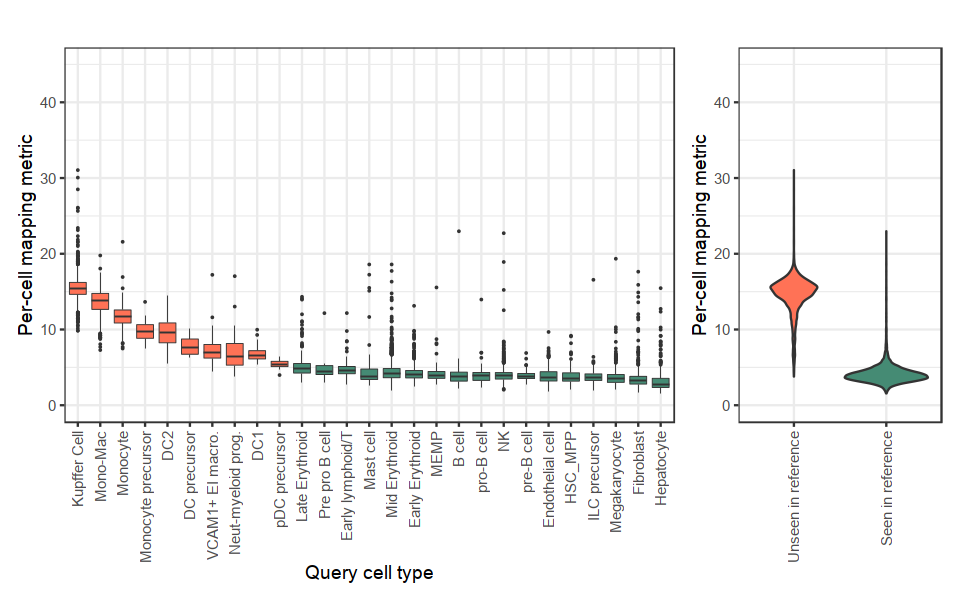

In [24]:
query$meta_data$per_cell_metric = calcPerCellMappingMetric(reference, query, Z_orig = TRUE)

query$meta_data$missing_in_reference = 'Unseen in reference'
query$meta_data$missing_in_reference[- which(query$meta_data$cell.labels %in% toremove)] = 'Seen in reference'
query$meta_data$missing_in_reference = as.factor(query$meta_data$missing_in_reference)

fig.size(5, 8)

cell.labels_order = reorder(query$meta_data$cell.labels, -query$meta_data$per_cell_metric)

p = ggplot(query$meta_data, aes(x = cell.labels_order, y = per_cell_metric, 
                            fill = missing_in_reference)) + theme_bw() + 
    geom_boxplot(outlier.size = 0.01, size = 0.2) + ylab('Per-cell mapping metric') + 
    xlab('Query cell type') + scale_fill_manual(values = colors) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ggtitle('') + theme(legend.position = 'none') +
    theme(legend.title = element_blank()) + theme(plot.title = element_text(hjust = 0.5), 
                                                  plot.subtitle = element_text(hjust = 0.5)) + ylim(0, 45)
q = ggplot(query$meta_data) + 
    geom_violin(aes(fill = missing_in_reference, y = per_cell_metric, 
                     x = reorder(missing_in_reference, - per_cell_metric))) + 
    theme(legend.title = element_blank()) + theme_bw() + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ylab('Per-cell mapping metric') + scale_fill_manual(values = colors) + xlab('') + ylim(0, 45)

myplot = p + q + plot_layout(widths = c(3, 1))

pdf(paste0('figs_fetal_liver/per_cell_metric_', filename_label, '.pdf'), 
    width = 8, height = 5, useDingbats = FALSE)
print(myplot)
dev.off()
myplot

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases



png 
  2

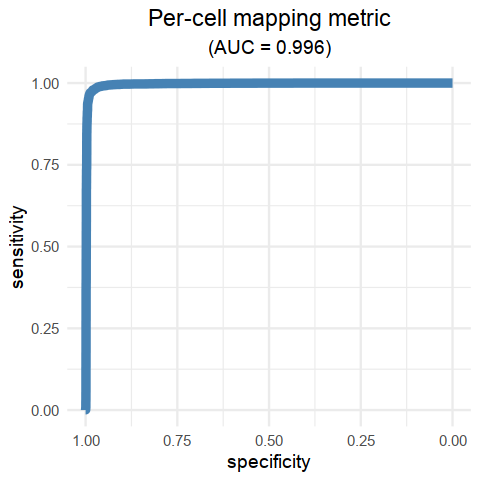

In [25]:
fig.size(4, 4)
rocobj = roc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric)
auc = round(auc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric), 3)

pdf(paste0('figs_fetal_liver/per_cell_auc_', filename_label, '.pdf'), 
    width = 4, height = 4, useDingbats = FALSE)
p = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Per-cell mapping metric')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
print(p)
dev.off()
p

Per-cluster mapping metric

In [26]:
per_cluster_metric = calcPerClusterMappingMetric(reference = reference, query = query, 
                         query_cluster_labels = query$meta_data$cell.labels, u = 2)
per_cluster_metric$missing_in_reference = per_cluster_metric$query_cluster %in% toremove
per_cluster_metric$seen_in_reference = 'Seen in reference'
per_cluster_metric$seen_in_reference[which(per_cluster_metric$missing_in_reference)] = 'Unseen in reference'

Calculating mapping confidence for 27 query clusters

(Warning) cluster contains too few cells to estimate confidence: pDC precursor

(Warning) cluster contains too few cells to estimate confidence: Pre pro B cell

(Warning) cluster contains too few cells to estimate confidence: DC precursor



In [27]:
# Order the cell types in the same order as above.
per_cluster_metric$query_cluster = factor(per_cluster_metric$query_cluster, 
                                          levels = levels(cell.labels_order))

Warning message:
“Removed 3 rows containing missing values (position_stack).”


png 
  2

Warning message:
“Removed 3 rows containing missing values (position_stack).”


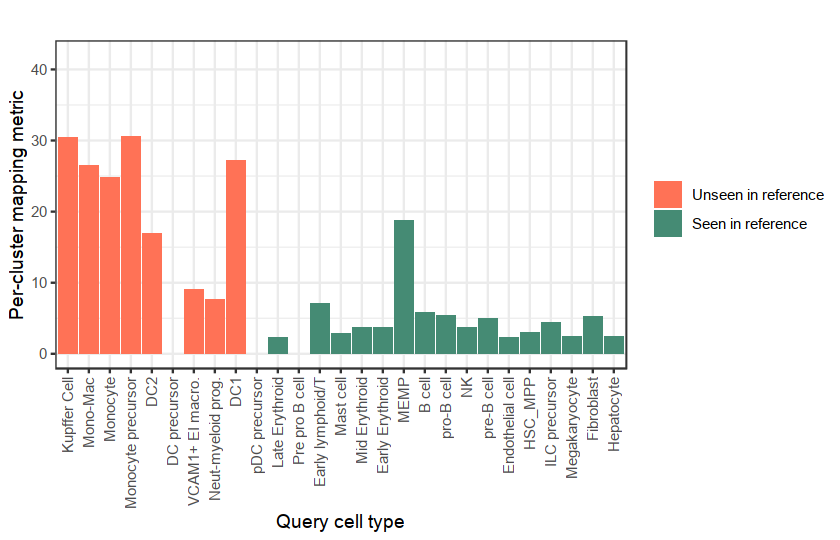

In [28]:
fig.size(4.5, 7)

p = ggplot(per_cluster_metric) +
    theme_bw() + 
    geom_bar(aes(x = query_cluster, y = distance_score, fill = seen_in_reference), stat = 'identity') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    scale_fill_manual(values = colors) + theme(legend.title = element_blank()) +
    ggtitle('') + theme(plot.title = element_text(hjust = 0.5)) + 
    ylab('Per-cluster mapping metric') + xlab('Query cell type') + ylim(0, 42)

pdf(paste0('figs_fetal_liver/per_cluster_metric_', filename_label, '.pdf'), 
    width = 7, height = 4.5, useDingbats = FALSE)
plot(p)
dev.off()
p

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases



png 
  2

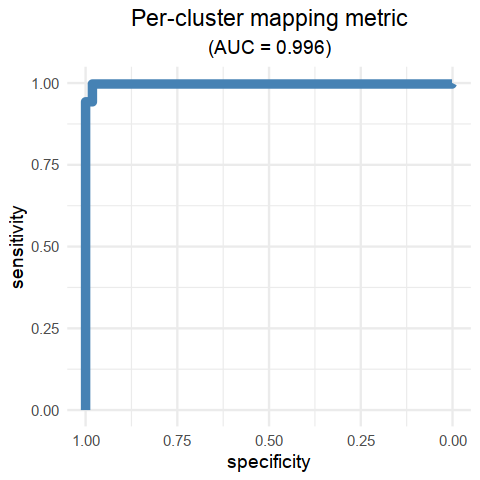

In [29]:
colnames(per_cluster_metric) = c('cell.labels', 'per_cluster_metric')
per_cluster = merge(x = query$meta_data, y = per_cluster_metric, by = "cell.labels", all.x = TRUE)

# For fairness, we set all NA values (small clusters for which we cannot estimate the covariance
# stabily) to 0.
per_cluster[is.na(per_cluster)] = 0

rocobj = roc(per_cluster$missing_in_reference, per_cluster$per_cluster_metric)
auc = round(auc(per_cluster$missing_in_reference, per_cluster$per_cluster_metric), 3)
    
fig.size(4, 4)
pdf(paste0('figs_fetal_liver/per_cluster_auc_', filename_label, '.pdf'), 
    width = 4, height = 4, useDingbats = FALSE)
p = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Per-cluster mapping metric')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
print(p)
dev.off()
p

# Reference missing Kupffer cells

## Build reference

Reference/query split
* Here, we will remove a donor for which there will be "unseen" non-immune cells.

In [30]:
toremove = c('Kupffer Cell') # change this line in other sections
filename_label = paste('missing', 'Kupffer', sep = '_')

outdir = '/data/srlab2/jkang/symphony_reproducibility/confidence_score/results_fetal_liver/'

print(filename_label)
table(metadata_3p$donor, metadata_3p$cell.labels)[donor, toremove]

[1] "missing_Kupffer"


[1] 6022

In [31]:
# Colors for each cell state - show 'present in reference' as grey
group.colors.missing = c(   'B cell'= 'lightgrey',
                    'DC precursor'='lightgrey',
                    'DC1'='lightgrey',
                    'DC2'='lightgrey',
                    'Early Erythroid'='lightgrey',
                    'Early lymphoid/T'='lightgrey',
                    'Endothelial cell'='lightgrey',
                    'Fibroblast'='lightgrey',
                    'Hepatocyte'='lightgrey',
                    'HSC_MPP'='lightgrey',
                    'ILC precursor'='lightgrey',
                    'Kupffer Cell'='#f283e3',
                    'Late Erythroid'='lightgrey',
                    'Mast cell'='lightgrey',
                    'Megakaryocyte'='lightgrey',
                    'MEMP'='lightgrey',
                    'Mid Erythroid'='lightgrey',
                    'Mono-Mac'='lightgrey',
                    'Monocyte'='lightgrey',
                    'Monocyte precursor'='lightgrey',
                    'Neut-myeloid prog.'='lightgrey',
                    'NK'='lightgrey',
                    'pDC precursor'='lightgrey',
                    'Pre pro B cell'='lightgrey',
                    'pre-B cell'='lightgrey',
                    'pro-B cell'='lightgrey',
                    'VCAM1+ EI macro.'='lightgrey')

In [32]:
idx_query = which(metadata_3p$donor %in% donor)

ref_exp = exprs_3p[, -idx_query]
ref_metadata = metadata_3p[-idx_query, ]
query_exp = exprs_3p[, idx_query]
query_metadata = metadata_3p[idx_query, ]

# Simulate an "unseen" cell type in the query
idx_toRemove = which(ref_metadata$cell.labels %in% toremove)

ref_exp = ref_exp[, -idx_toRemove]
ref_metadata = ref_metadata[-idx_toRemove, ]

ncol(ref_exp)
ncol(query_exp)

[1] 77299

[1] 16945

Normalize, variable genes, PCA

Follow the original authors' variable gene selection process: https://github.com/haniffalab/FCA_liver/blob/master/pipelines/06_add_dr/add_dr.R

In [45]:
ref_exp_norm = singlecellmethods::normalizeData(ref_exp, 1e4, 'log')

## Same vargene selection procedure as Popescue et al.
groups = rep('A', ncol(ref_exp_norm))
vargenes = singlecellmethods::findVariableGenes(ref_exp_norm, groups = groups, 
                                                min_expr = .0125, max_expr = 3, min_dispersion = 0.625)
nrow(vargenes)
ref_exp_vargenes = ref_exp_norm[vargenes$symbol, ]
vargenes_means_sds = tibble(symbol = vargenes$symbol, mean = Matrix::rowMeans(ref_exp_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp_vargenes, vargenes_means_sds$mean)
ref_exp_scaled = singlecellmethods::scaleDataWithStats(ref_exp_vargenes, vargenes_means_sds$mean, 
                                                       vargenes_means_sds$stddev, 1)

set.seed(1)
# Run SVD, save gene loadings
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs x cells]
loadings = s$u

[1] 2015

Harmony

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 3864950)”
Warning message:
“did not converge in 25 iterations”


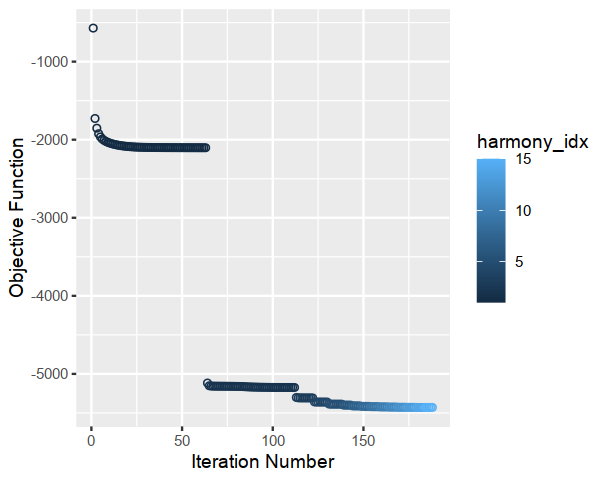

In [46]:
fig.size(4, 5)
set.seed(1)
# Harmonize the reference
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(3),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE,           ## do not recompute PCs
        plot_convergence = TRUE,
        verbose = FALSE
)

Symphony compression

In [47]:
# Compress Harmony obj into a Symphony reference
reference = buildReferenceFromHarmonyObj(
                ref_harmObj,            # output object from HarmonyMatrix()
                ref_metadata,
                vargenes_means_sds,     # gene names, means, and std devs for scaling
                loadings,               # genes x PCs
                verbose = TRUE, 
                do_umap = TRUE,
                umap_min_dist = 0.3, 
                save_uwot_path = paste0(outdir, filename_label, '_uwot_model'))

saveRDS(reference, paste0(outdir, filename_label, '_reference.rds'))

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model

Finished nicely.



Plot reference

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Adding missing grouping variables: `cell.labels`



png 
  2

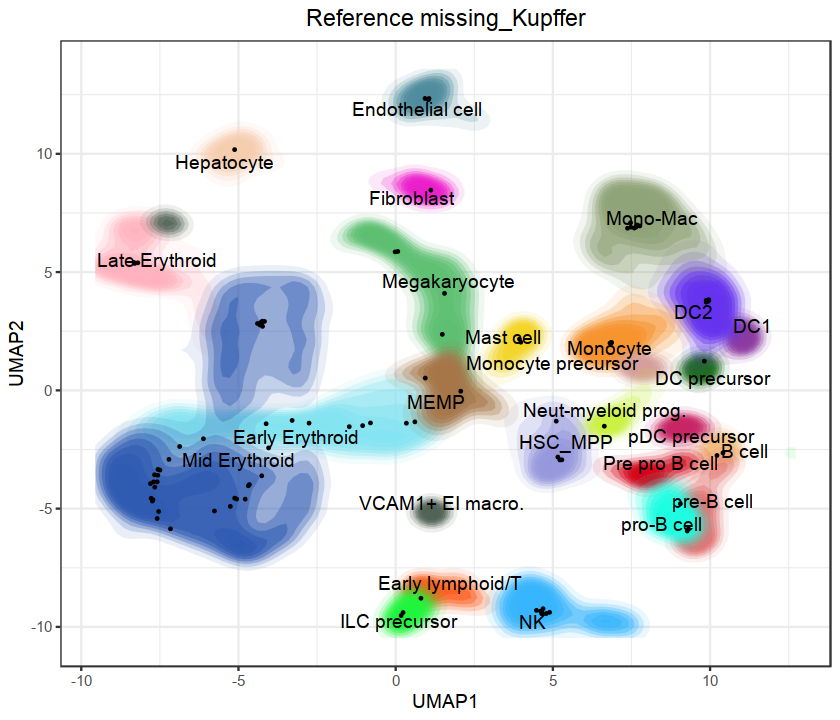

In [48]:
fig.size(6, 7)
p = symphony::plotReference(reference, color.by = 'cell.labels',
                        as.density = TRUE, show.centroids = TRUE, celltype.colors = group.colors,
                        title = paste0('Reference ', filename_label)) + theme(legend.position = 'none')
pdf(paste0('figs_fetal_liver/', filename_label, '_ref_umap.pdf'), width = 7, height = 6, useDingbats = FALSE)
print(p)
dev.off()
p

## Map held-out query

In [29]:
dim(query_exp)
dim(query_metadata)

[1] 27080 16945

[1] 16945    18

In [30]:
reference = readRDS(paste0(outdir, filename_label, '_reference.rds'))
query = mapQuery(query_exp, query_metadata, reference, vars = c('donor'), do_normalize = TRUE)

Normalizing

Scaling and synchronizing query gene expression

Found 2015 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [31]:
saveRDS(query, paste0(outdir, filename_label, '_query.rds'))

## Plotting

In [33]:
query = readRDS(paste0(outdir, filename_label, '_query.rds'))
reference = readRDS(paste0(outdir, filename_label, '_reference.rds'))

In [34]:
# Sync column names
r_metadata = reference$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor')]
q_metadata = query$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor')]
colnames(q_metadata) = colnames(r_metadata)

r_metadata$ref_query = 'reference'
q_metadata$ref_query = 'query'
meta_data_combined = rbind(q_metadata, r_metadata)

# Add the UMAP coordinates to the metadata
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# To plot query cells on top
umap_combined_labels = umap_combined_labels[order(- as.numeric(factor(umap_combined_labels$ref_query))),]

Adding missing grouping variables: `cell.labels`



png 
  2

png 
  2

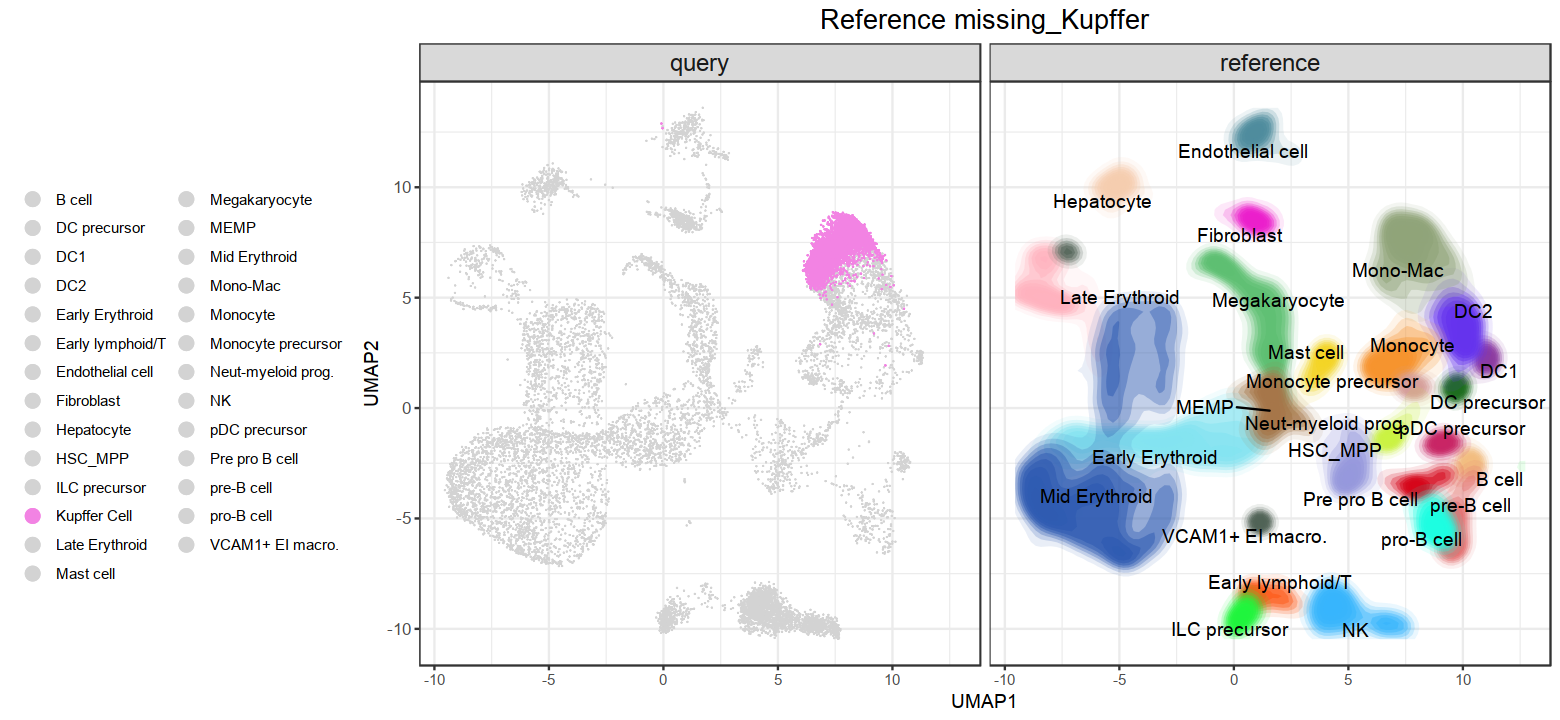

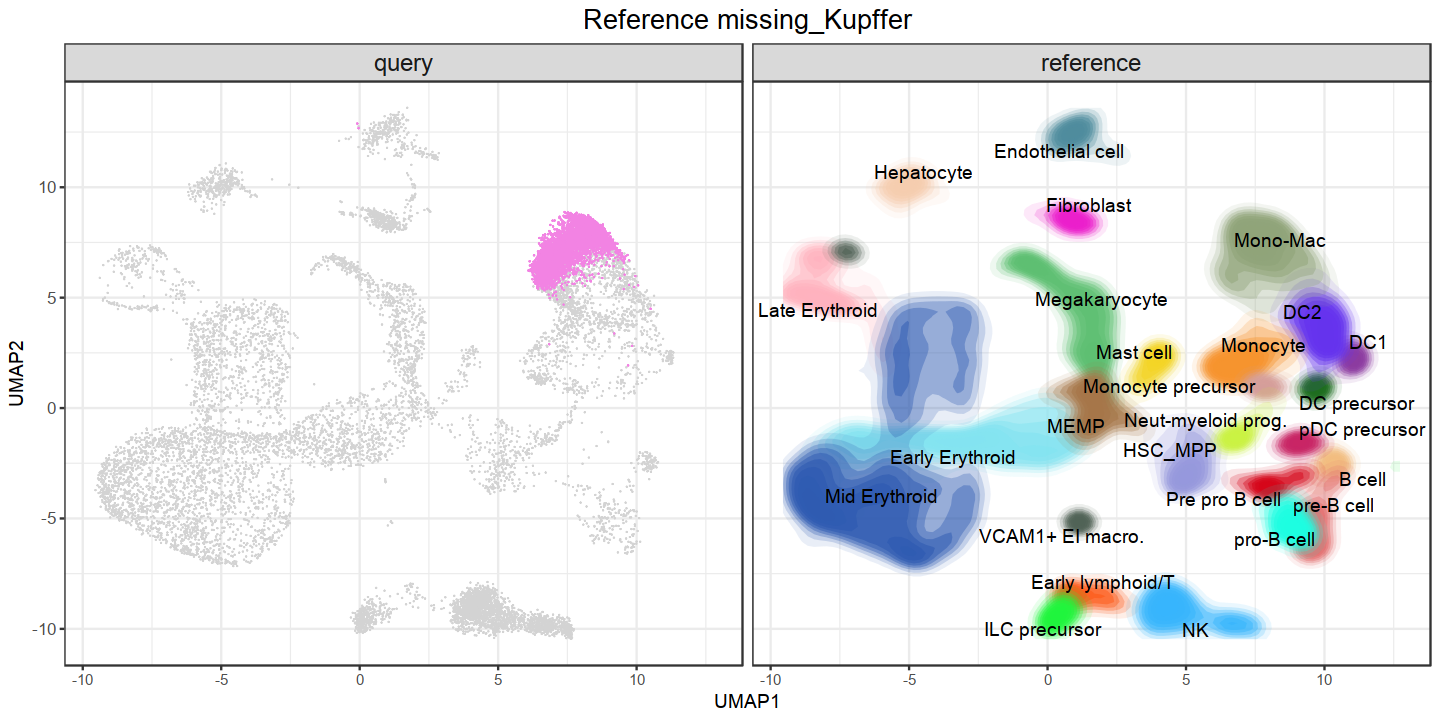

In [35]:
res = umap_combined_labels
res_ref = res[which(res$ref_query == 'reference'), ]
res_new = res[which(res$cell.labels %in% toremove), ]

# Make cell type labels
labels.cent = res_ref %>% 
    dplyr::group_by(cell.labels) %>%
    dplyr::select(UMAP1, UMAP2) %>% 
    summarize_all(median)

p = res_ref %>%
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell.labels), 
                        contour_var = "ndensity", bins = 10, h = 1.5, show.legend = FALSE) +
        geom_point_rast(data = res[which(res$ref_query == 'query'), ], 
                   aes(x = UMAP1, y = UMAP2, color = cell.labels), size = 0.4, stroke = 0.3, shape = 16) +
        # plot unseen cells on top
        geom_point_rast(data = res_new, 
                   aes(x = UMAP1, y = UMAP2, color = cell.labels), size = 0.4, stroke = 0.3, shape = 16) +
        theme_bw() +
        labs(title = '', color = '', fill = '') + 
        ggtitle(paste0('Reference ', filename_label)) +
        theme(plot.title = element_text(hjust = 0.5, size = 16)) + 
        scale_fill_manual(values = group.colors) + guides(colour = guide_legend(override.aes = list(size = 4))) +
        scale_color_manual(values = group.colors.missing) + facet_wrap(~ref_query) +
        theme(axis.text.y = element_text(hjust = 1, size=10), strip.text.x = element_text(size=14)) +
        theme(legend.position = 'left') +
        ggrepel::geom_text_repel(data = data.frame(labels.cent, ref_query = 'reference'), 
                                 aes(label = cell.labels), color = 'black', size = 4, max.overlaps = 27) 
fig.size(6, 13)
pdf(paste0('figs_fetal_liver/', filename_label, '_query_umap.pdf'), width = 13, height = 6, useDingbats = FALSE)
print(p)
dev.off()
p

fig.size(6, 12)
q = p + theme(legend.position = 'none')
pdf(paste0('figs_fetal_liver/', filename_label, '_query_umap_nolegend.pdf'), width = 12, height = 6, useDingbats = FALSE)
print(q)
dev.off()
q

## Calculate mapping quality scores

Per-cell mapping metric

png 
  2

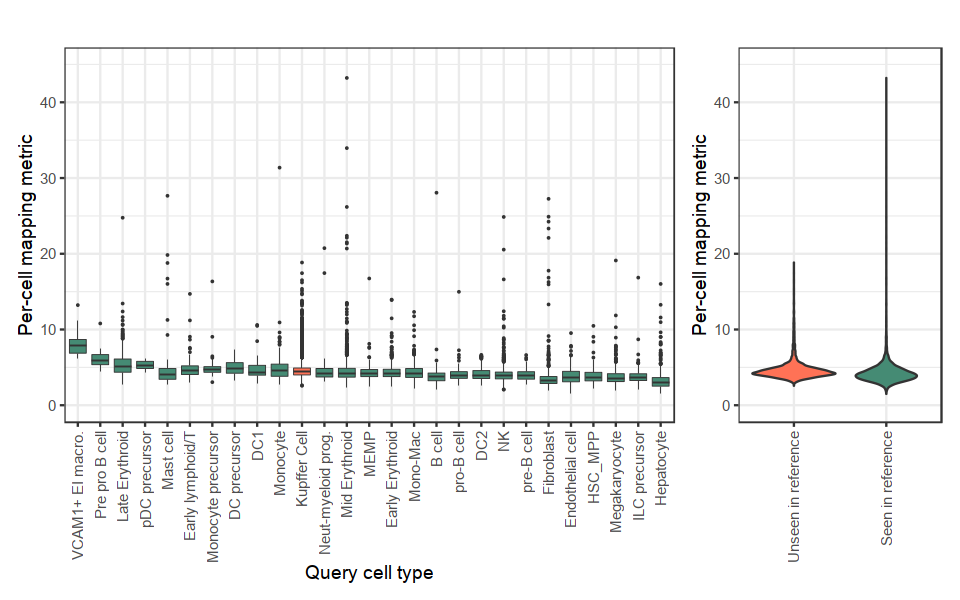

In [36]:
query$meta_data$per_cell_metric = calcPerCellMappingMetric(reference, query, Z_orig = TRUE)

query$meta_data$missing_in_reference = 'Unseen in reference'
query$meta_data$missing_in_reference[- which(query$meta_data$cell.labels %in% toremove)] = 'Seen in reference'
query$meta_data$missing_in_reference = as.factor(query$meta_data$missing_in_reference)

fig.size(5, 8)

cell.labels_order = reorder(query$meta_data$cell.labels, -query$meta_data$per_cell_metric)

p = ggplot(query$meta_data, aes(x = reorder(cell.labels, -per_cell_metric), y = per_cell_metric, 
                            fill = missing_in_reference)) + theme_bw() + 
    geom_boxplot(outlier.size = 0.01, size = 0.2) + ylab('Per-cell mapping metric') + 
    xlab('Query cell type') + scale_fill_manual(values = colors) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ggtitle('') + theme(legend.position = 'none') +
    theme(legend.title = element_blank()) + theme(plot.title = element_text(hjust = 0.5), 
                                                  plot.subtitle = element_text(hjust = 0.5)) + ylim(0, 45)
q = ggplot(query$meta_data) + 
    geom_violin(aes(fill = missing_in_reference, y = per_cell_metric, 
                     x = reorder(missing_in_reference, - per_cell_metric))) + 
    theme(legend.title = element_blank()) + theme_bw() + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ylab('Per-cell mapping metric') + scale_fill_manual(values = colors) + xlab('') + ylim(0, 45)

myplot = p + q + plot_layout(widths = c(3, 1))

pdf(paste0('figs_fetal_liver/per_cell_metric_', filename_label, '.pdf'), 
    width = 8, height = 5, useDingbats = FALSE)
print(myplot)
dev.off()
myplot

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases



png 
  2

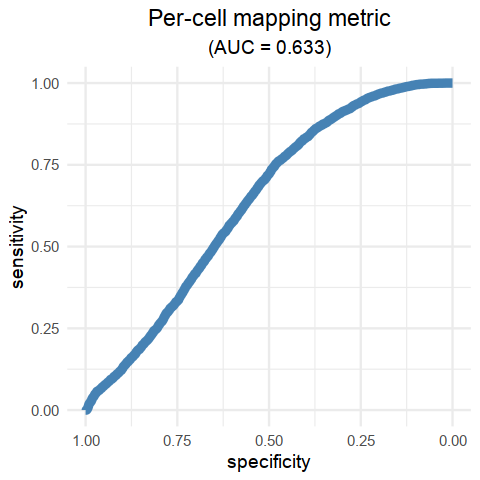

In [37]:
fig.size(4, 4)
rocobj = roc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric)
auc = round(auc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric), 3)

pdf(paste0('figs_fetal_liver/per_cell_auc_', filename_label, '.pdf'), 
    width = 4, height = 4, useDingbats = FALSE)
p = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Per-cell mapping metric')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
print(p)
dev.off()
p

Per-cluster mapping metric

In [38]:
per_cluster_metric = calcPerClusterMappingMetric(reference = reference, query = query, 
                         query_cluster_labels = query$meta_data$cell.labels, u = 2)
per_cluster_metric$missing_in_reference = per_cluster_metric$query_cluster %in% toremove
per_cluster_metric$seen_in_reference = 'Seen in reference'
per_cluster_metric$seen_in_reference[which(per_cluster_metric$missing_in_reference)] = 'Unseen in reference'

Calculating mapping confidence for 27 query clusters

(Warning) cluster contains too few cells to estimate confidence: pDC precursor

(Warning) cluster contains too few cells to estimate confidence: Pre pro B cell

(Warning) cluster contains too few cells to estimate confidence: DC precursor



In [39]:
# Order the cell types in the same order as above.
per_cluster_metric$query_cluster = factor(per_cluster_metric$query_cluster, levels = levels(cell.labels_order))

Warning message:
“Removed 3 rows containing missing values (position_stack).”


png 
  2

Warning message:
“Removed 3 rows containing missing values (position_stack).”


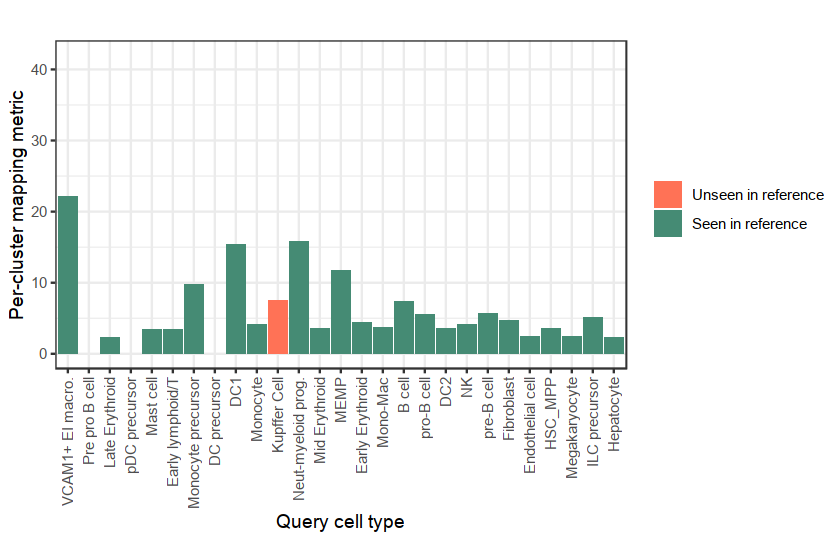

In [40]:
fig.size(4.5, 7)

p = ggplot(per_cluster_metric) +
    theme_bw() + 
    geom_bar(aes(x = query_cluster, y = distance_score, fill = seen_in_reference), stat = 'identity') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    scale_fill_manual(values = colors) + theme(legend.title = element_blank()) +
    ggtitle('') + theme(plot.title = element_text(hjust = 0.5)) + 
    ylab('Per-cluster mapping metric') + xlab('Query cell type') + ylim(0, 42)

pdf(paste0('figs_fetal_liver/per_cluster_metric_', filename_label, '.pdf'), 
    width = 7, height = 4.5, useDingbats = FALSE)
plot(p)
dev.off()
p

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases



png 
  2

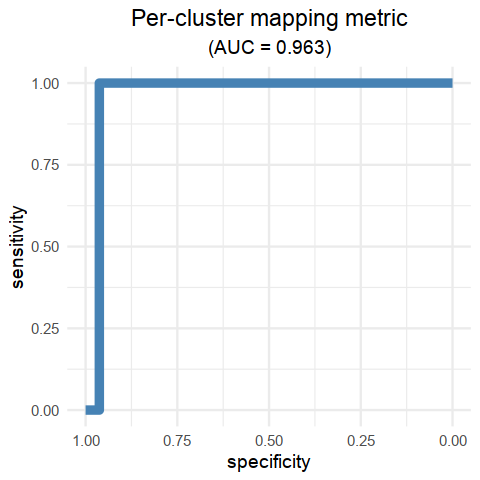

In [41]:
colnames(per_cluster_metric) = c('cell.labels', 'per_cluster_metric')
per_cluster = merge(x = query$meta_data, y = per_cluster_metric, by = "cell.labels", all.x = TRUE)

# For fairness, we set all NA values (small clusters for which we cannot estimate the covariance
# stabily) to 0.
per_cluster[is.na(per_cluster)] = 0

rocobj = roc(per_cluster$missing_in_reference, per_cluster$per_cluster_metric)
auc = round(auc(per_cluster$missing_in_reference, per_cluster$per_cluster_metric), 3)
    
fig.size(4, 4)
pdf(paste0('figs_fetal_liver/per_cluster_auc_', filename_label, '.pdf'), 
    width = 4, height = 4, useDingbats = FALSE)
p = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Per-cluster mapping metric')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
print(p)
dev.off()
p

# All done!

In [42]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pROC_1.17.0.1           ggthemes_4.2.4          patchwork_1.1.1        
 [4] ggrepel_0.9.1           ggpubr_0.4.0            ggrastr_0.2.3          
 [7] RColorBrewer_1.1-2      pheatmap_1.0.12         biomaRt_2.46.3         
[10] symphony_1.0            Seurat